In [1]:
from runlmc.models.lmc import LMC
from runlmc.kern.rbf import RBF
from runlmc.models.optimization import AdaDelta

import numpy as np

%matplotlib inline 
import matplotlib.pyplot as plt

np.random.seed(1234)

In [2]:
n_per_output = [65, 100]
xss = list(map(np.random.rand, n_per_output))
nout = len(n_per_output)
yss = [np.sin(2 * np.pi * xs + i * 2 * np.pi / nout)
       + np.random.randn(len(xs)) * (i + 1) * 0.1 / nout
       for i, xs in enumerate(xss)]
ks = [RBF(name='rbf{}'.format(i)) for i in range(nout)]

In [3]:
def print_diagram(lmc):
    plot_xs =  np.arange(0, 1, 0.01)
    ys, var = lmc.predict([plot_xs for _ in range(nout)])
    for i, (y, v, xs, ys) in enumerate(zip(ys, var, xss, yss)):
        sd = np.sqrt(v)
        order = xs.argsort()
        plt.scatter(xs[order], ys[order])
        plt.title('output {} (95%)'.format(i))
        plt.plot(plot_xs, y)
        plt.plot(plot_xs, y + 2 * sd, ls='--', c='g')
        plt.plot(plot_xs, y - 2 * sd, ls='--', c='g')
        plt.show()

env: OMP_NUM_THREADS=1


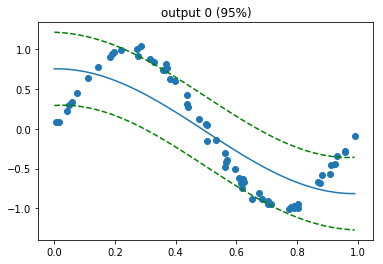

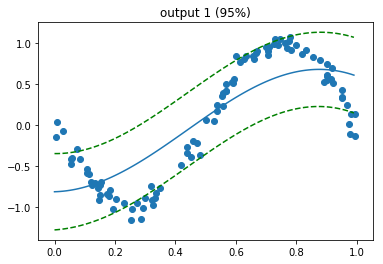

In [4]:
# Unoptimized
%env OMP_NUM_THREADS=1
lmc = LMC(xss, yss, kernels=ks)
print_diagram(lmc)

starting adadelta {'step_rate': 1, 'decay': 0.9, 'momentum': 0.5, 'offset': 0.0001, 'max_it': 100, 'verbosity': 10, 'min_grad_ratio': 0.1, 'permitted_drops': 5, 'callback': <function AdaDelta.noop at 0x7f0f177772f0>}
iteration       10 grad norm 2.9819e+01
iteration       20 grad norm 3.0390e+01
iteration       30 grad norm 6.8893e+00
finished adadelta optimization
            34 iterations
    3.9673e+00 final grad norm
    norm used inf

Name : lmc
Objective : -103.96266081091647
Number of Parameters : 12
Number of Optimization Parameters : 12
Updates : True
Parameters:
  lmc.                  |          value  |  constraints  |  priors
  rbf0.inv_lengthscale  |  2.66356032218  |      +ve      |        
  rbf1.inv_lengthscale  |  4.29828951576  |      +ve      |        
  a0                    |         (1, 2)  |               |        
  a1                    |         (1, 2)  |               |        
  kappa0                |           (2,)  |      +ve      |        
  kappa1     

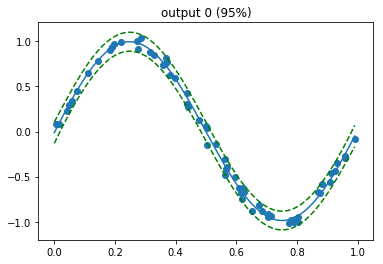

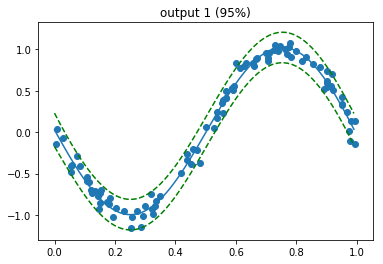

In [5]:
lmc.optimize(optimizer=AdaDelta(verbosity=10))
#optimized
print(lmc)
print(lmc.noise)
print_diagram(lmc)

In [6]:
import GPy

rbfs = [GPy.kern.RBF(1) for _ in range(nout)]
# not exactly the same since mine is rank-1 only for now
# This is why we need as many kernels as outputs, because we'd be rank-deficient o/w
k = GPy.util.multioutput.LCM(input_dim=1,num_outputs=nout,kernels_list=rbfs)
xss_reshaped = [xs.reshape(-1, 1) for xs in xss]
yss_reshaped = [ys.reshape(-1, 1) for ys in yss]
m = GPy.models.GPCoregionalizedRegression(
    xss_reshaped, yss_reshaped, kernel=k)
m.optimize()
print(m)


Name : gp
Objective : -180.15398313362545
Number of Parameters : 14
Number of Optimization Parameters : 14
Updates : True
Parameters:
  gp.                                    |              value  |  constraints  |  priors
  sum.ICM0.rbf.variance                  |   0.00352213798589  |      +ve      |        
  sum.ICM0.rbf.lengthscale               |     0.339637934475  |      +ve      |        
  sum.ICM0.B.W                           |             (2, 1)  |               |        
  sum.ICM0.B.kappa                       |               (2,)  |      +ve      |        
  sum.ICM1.rbf.variance                  |  1.07537498519e-09  |      +ve      |        
  sum.ICM1.rbf.lengthscale               |      28.8062520462  |      +ve      |        
  sum.ICM1.B.W                           |             (2, 1)  |               |        
  sum.ICM1.B.kappa                       |               (2,)  |      +ve      |        
  mixed_noise.Gaussian_noise_0.variance  |   0.00250691305146  |

 /home/vlad/dev/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


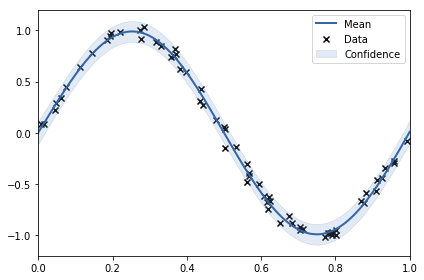

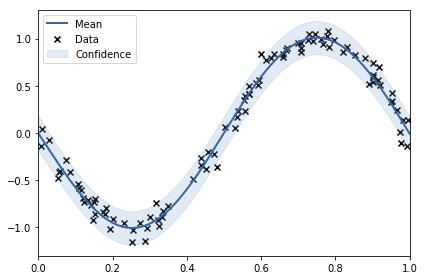

In [7]:
# Plotting code adapted from GPy coregionalization tutorial
# Also 95% confidence

data_rows = np.add.accumulate(n_per_output)
data_rows = np.insert(data_rows, 0, 0)

for i in range(nout):
    m.plot(
        plot_limits=(0, 1),
        fixed_inputs=[(1,i)],
        which_data_rows=slice(data_rows[i],data_rows[i + 1]))

In [8]:
# Adding a prior
from runlmc.parameterization.priors import InverseGamma, Gaussian, HalfLaplace

ig = InverseGamma(0.5, 0.5)
lmc.rbf0.inv_lengthscale.set_prior(ig)
lmc.rbf1.inv_lengthscale.set_prior(ig)

n = Gaussian(0, 1)
lmc.a0.set_prior(n)
lmc.a1.set_prior(n)

h = HalfLaplace(1)
lmc.kappa0.set_prior(h)
lmc.kappa1.set_prior(h)

lmc.optimize()

print(lmc)
print(lmc.kappa0)


Name : lmc
Objective : -71.721704290659
Number of Parameters : 12
Number of Optimization Parameters : 12
Updates : True
Parameters:
  lmc.                  |          value  |  constraints  |         priors        
  rbf0.inv_lengthscale  |  2.66030662336  |      +ve      |  InverseGamma(0.5,0.5)
  rbf1.inv_lengthscale  |  4.84285731773  |      +ve      |  InverseGamma(0.5,0.5)
  a0                    |         (1, 2)  |               |         N(0, 1)       
  a1                    |         (1, 2)  |               |         N(0, 1)       
  kappa0                |           (2,)  |      +ve      |     HalfLaplace(1)    
  kappa1                |           (2,)  |      +ve      |     HalfLaplace(1)    
  noise                 |           (2,)  |      +ve      |                       
  index  |  lmc.kappa0  |  constraints  |      priors    
  [0]    |  1.19411758  |      +ve      |  HalfLaplace(1)
  [1]    |  1.46157525  |      +ve      |  HalfLaplace(1)


In [9]:
# Multilevel prior
from runlmc.parameterization.param import Param

# A param is anything that is unconstrained during the optimization
# We add a param shape such that
# shape ~ IG(0.5, 0.5)
# rbf*.inv_lengthscale ~ IG(0.5, shape)

ig = InverseGamma(0.5, 0.5)
initial_value = 1
shape = Param('shape', initial_value)
lmc.link_parameter(shape) # wire the parameter into the model (otherwise it won't get updated)
shape.set_prior(ig)

ig2 = InverseGamma(0.5, shape)
for il in [lmc.rbf0.inv_lengthscale, lmc.rbf1.inv_lengthscale]:
    il.set_prior(ig2)
    
lmc.optimize(optimizer=AdaDelta())
print(lmc)
print(lmc.kappa0)


Name : lmc
Objective : -81.06214113470668
Number of Parameters : 13
Number of Optimization Parameters : 13
Updates : True
Parameters:
  lmc.                  |           value  |  constraints  |          priors         
  rbf0.inv_lengthscale  |  0.433700894093  |      +ve      |  InverseGamma(0.5,shape)
  rbf1.inv_lengthscale  |   8.54013209271  |      +ve      |  InverseGamma(0.5,shape)
  a0                    |          (1, 2)  |               |          N(0, 1)        
  a1                    |          (1, 2)  |               |          N(0, 1)        
  kappa0                |            (2,)  |      +ve      |      HalfLaplace(1)     
  kappa1                |            (2,)  |      +ve      |      HalfLaplace(1)     
  noise                 |            (2,)  |      +ve      |                         
  shape                 |  0.333333333331  |      +ve      |   InverseGamma(0.5,0.5) 
  index  |    lmc.kappa0  |  constraints  |      priors    
  [0]    |    0.00326931  |    